# Предсказание вероятности оттока клиентов фитнес-зала

**Необходимые библиотеки**

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import shap

# **Загрузка и анализ данных**

In [2]:
df = pd.read_csv('gym_churn_us.csv')

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [9]:
df.shape

(4000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [8]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


## Краткие выводы по датасету:
### Первичный анализ данных
- Всего 4000 клиентов, 14 признаков, пропусков нет.  
- 26.5% клиентов ушли (churn=1), 73.5% остались, дисбаланс классов умеренный.  
- Большинство признаков бинарные (0/1), что упростит обработку.  
- Возраст клиентов в среднем ~29 лет, диапазон 18–41.  
- Контракт чаще всего на 1 месяц, но есть до 12 месяцев.  
- Доп. расходы сильно варьируются (от ~0 до >500), что может быть важным фактором churn.  
- У части клиентов частота посещений = 0 => возможный сигнал риска оттока.


# **EDA**

## Баланс классов

In [10]:
churn_counts = df['Churn'].value_counts(normalize=True) * 100
print(churn_counts)

Churn
0    73.475
1    26.525
Name: proportion, dtype: float64


/tmp/ipython-input-1689543225.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set1')


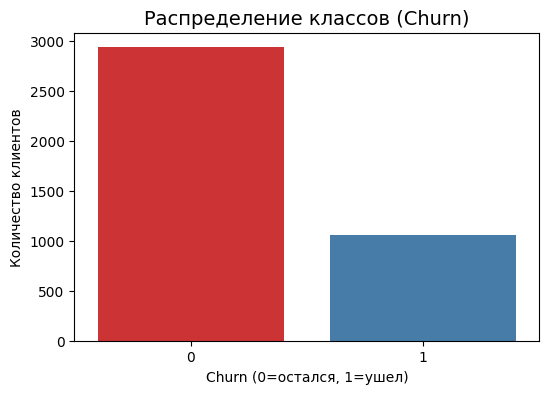

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='Set1')
plt.title("Распределение классов (Churn)", fontsize=14)
plt.xlabel("Churn (0=остался, 1=ушел)")
plt.ylabel("Количество клиентов")
plt.show()

## Анализ числовых признаков

/tmp/ipython-input-520828147.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=feature, data=df, palette='Set1')
/tmp/ipython-input-520828147.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=feature, data=df, palette='Set1')
/tmp/ipython-input-520828147.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=feature, data=df, palette='Set1')
/tmp/ipython-input-520828147.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` vari

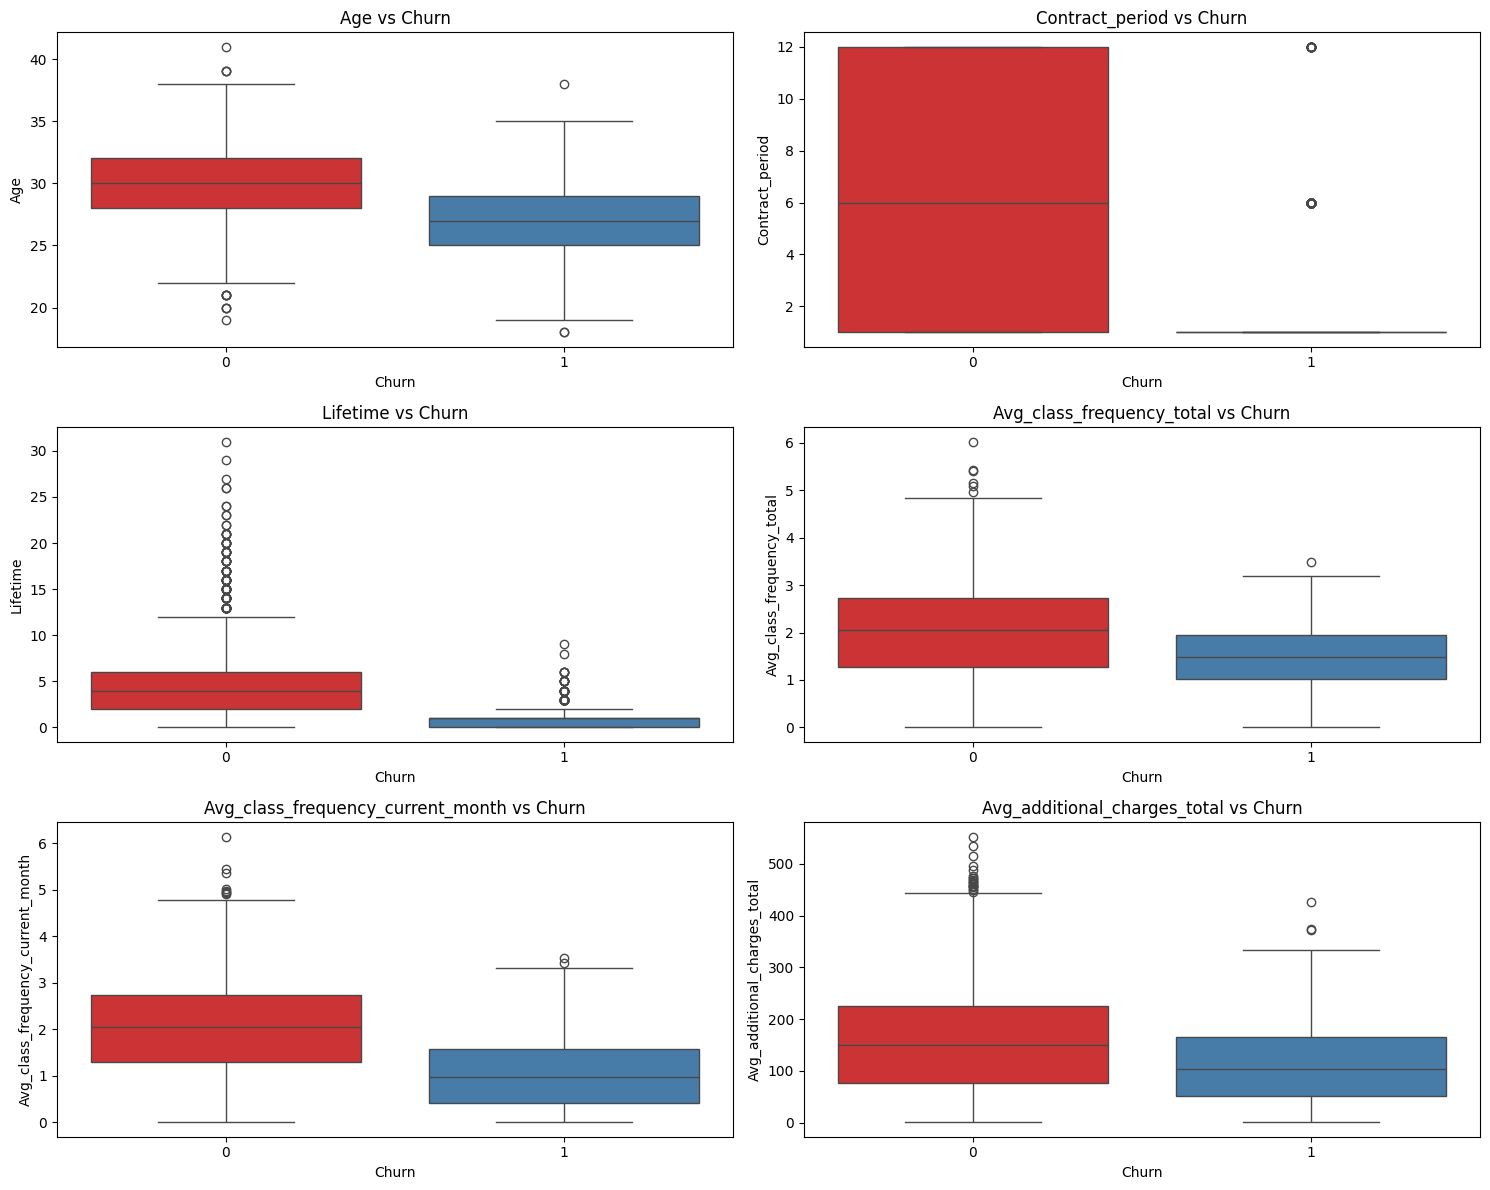

In [15]:
num_features = [
    'Age',
    'Contract_period',
    'Lifetime',
    'Avg_class_frequency_total',
    'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
]

plt.figure(figsize=(15, 12))

for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Churn', y=feature, data=df, palette='Set1')
    plt.title(f"{feature} vs Churn")

plt.tight_layout()
plt.show()

### Выводы по числовым признакам
- **Контракт**: клиенты с месячными контрактами значительно чаще уходят, чем с годовыми.  
- **Lifetime**: чем дольше клиент в клубе, тем меньше вероятность оттока.  
- **Активность**: низкая общая посещаемость и особенно падение активности в последнем месяце - ключевые факторы риска.  
- **Доп. траты**: клиенты, которые тратят больше на дополнительные услуги, реже уходят.  
- **Возраст**: небольшая тенденция - более молодые клиенты чаще уходят, но фактор слабее.  

## Анализ категориальных признаков

/tmp/ipython-input-2719626294.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='Set1')
/tmp/ipython-input-2719626294.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='Set1')
/tmp/ipython-input-2719626294.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='Set1')
/tmp/ipython-input-2719626294.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

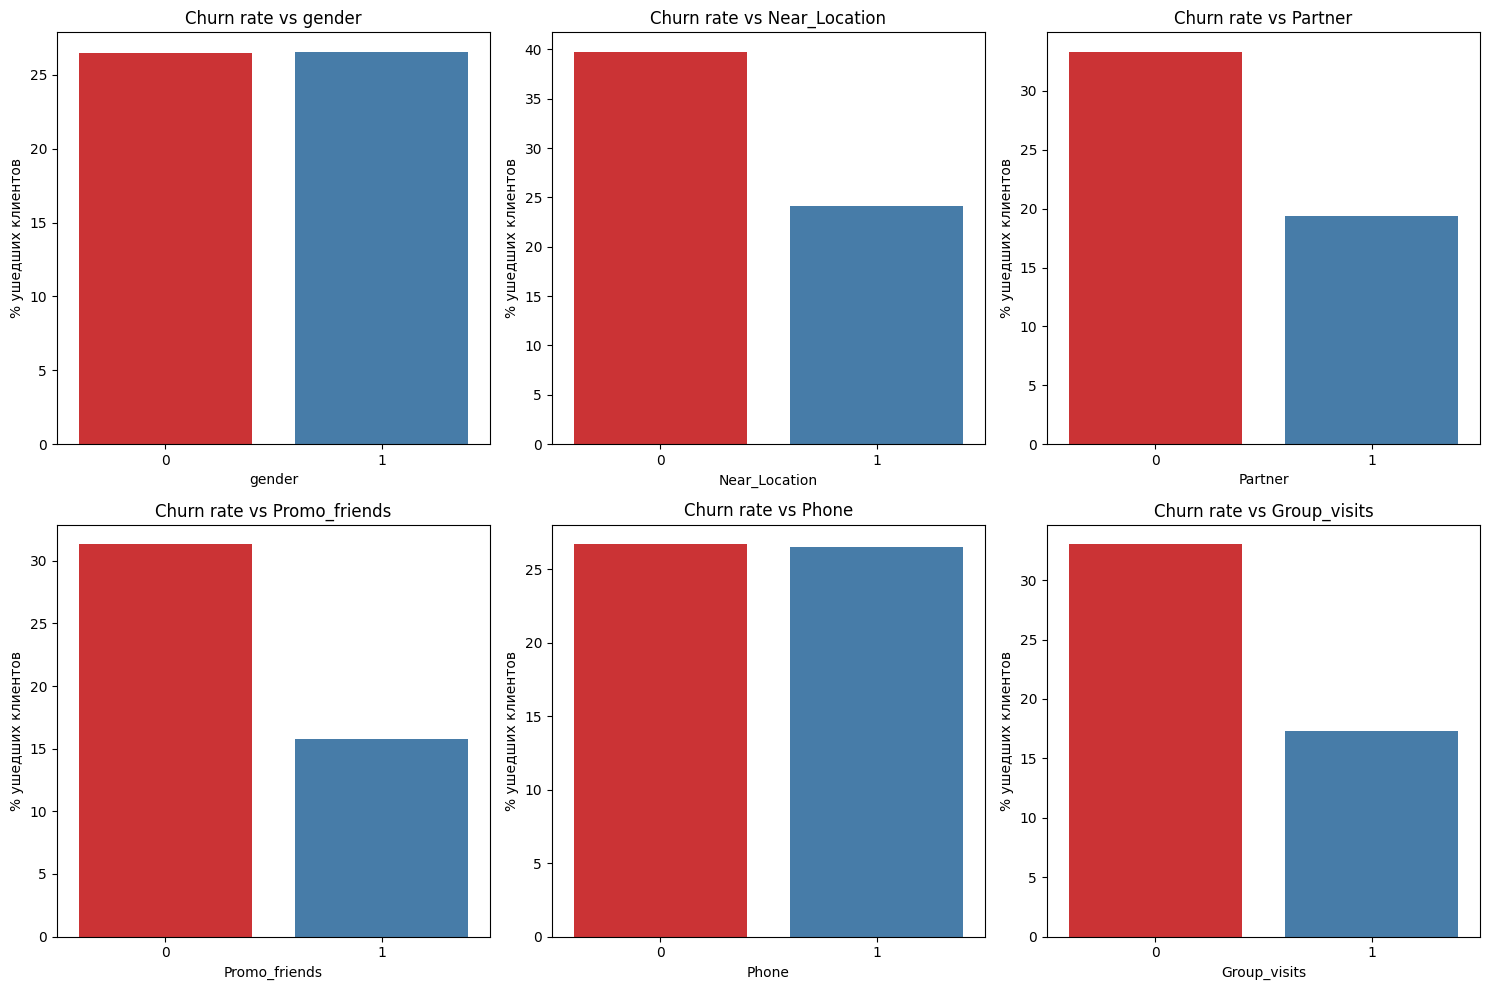

In [14]:
cat_features = [
    'gender',
    'Near_Location',
    'Partner',
    'Promo_friends',
    'Phone',
    'Group_visits'
]

plt.figure(figsize=(15, 10))

for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    churn_rate = df.groupby(feature)['Churn'].mean() * 100
    sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='Set1')
    plt.title(f"Churn rate vs {feature}")
    plt.ylabel("% ушедших клиентов")
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

### Выводы по категориальным признакам
- **Пол**: пол клиента существенно не влияет на вероятность оттока.  
- **Near location**: клиенты, живущие или работающие рядом с фитнес-залом, уходят реже.  
- **Partner**: клиенты, являющиеся сотрудниками компаний-партнерова, уйдут с меньшей вероятностью.  
- **Promo friends**: клиенты, вовлеченные по реферальной системе, уходят реже.  
- **Phone**: наличие номера телефона клиента в базе фитнес-зала не оказывает существенное влияние на вероятность его ухода.  
- **Group visits**: клиент, не посещавший групповые занятия, с большей вероятностью уйдет.

# **Feature-engineering и подготовка данных**

## Создаем новые признаки

**contract_left_ratio** = Month_to_end_contract / Contract_period => доля времени до конца контракта.

**avg_freq_diff** = Avg_class_frequency_current_month - Avg_class_frequency_total => упал ли интерес/активность.

**activity_drop_flag** = (avg_freq_diff < 0).astype(int) => бинарный индикатор снижения активности.

In [18]:
df['contract_left_ratio'] = df['Month_to_end_contract'] / df['Contract_period']
df['avg_freq_diff'] = df['Avg_class_frequency_current_month'] - df['Avg_class_frequency_total']
df['activity_drop_flag'] = (df['avg_freq_diff'] < 0).astype(int)

## Подготавливаем данные для модели

Выбрали признаки и целевую переменную

In [19]:
features = [
    'gender',
    'Near_Location',
    'Partner',
    'Promo_friends',
    'Phone',
    'Group_visits',
    'Age',
    'Contract_period',
    'Lifetime',
    'Avg_class_frequency_total',
    'Avg_class_frequency_current_month',
    'Avg_additional_charges_total',
    'Month_to_end_contract',

    'contract_left_ratio',
    'avg_freq_diff',
    'activity_drop_flag'
]

X = df[features]
y = df['Churn']

Разбиение выборки

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,)

Масштабирование

In [63]:
scaler = StandardScaler()
num_features = [
    'Age', 'Contract_period', 'Lifetime',
    'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
    'Avg_additional_charges_total', 'Month_to_end_contract',
    'contract_left_ratio', 'avg_freq_diff'
]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

# **Построение модели**

## Обучаем baseline-модель (LORGEG)

In [23]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [24]:
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

In [25]:
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
print(f"AUC-ROC: {auc:.3f}")
print(f"F1-score: {f1:.3f}\n")

AUC-ROC: 0.974
F1-score: 0.841



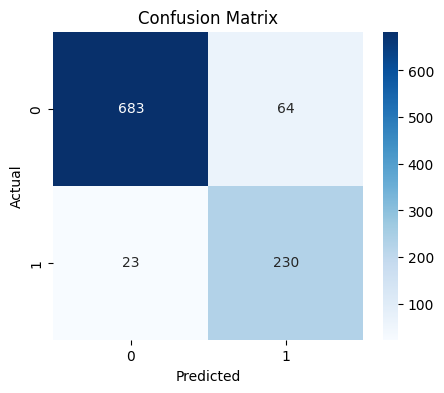

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

-  AUC-ROC = 0.974, F1-score = 0.841 => модель хорошо различает ушедших и оставшихся клиентов.

In [27]:
coef_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coef': logreg.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)
print(coef_df)

                              feature      coef
8                            Lifetime -3.615932
14                      avg_freq_diff -1.337678
6                                 Age -1.137618
12              Month_to_end_contract -0.807960
5                        Group_visits -0.735105
10  Avg_class_frequency_current_month -0.619633
3                       Promo_friends -0.582248
7                     Contract_period -0.552063
11       Avg_additional_charges_total -0.542754
15                 activity_drop_flag -0.341758
0                              gender  0.237905
9           Avg_class_frequency_total -0.225310
1                       Near_Location -0.191969
13                contract_left_ratio  0.123121
4                               Phone -0.119709
2                             Partner -0.077518


Бейзлайн-модель дает неплохие показатели, но стоит так же протестировать модели посложнее, чтоб уловить нелинейные зависимости, которые логистическая регрессия не видит.

## Обучаем более сложную модель (RandomForest)

In [72]:
rf = RandomForestClassifier(
    n_estimators=200,       # количество деревьев
    max_depth=6,            # ограничиваем глубину для предотвращения переобучения
    random_state=42,
    class_weight='balanced' # учитываем дисбаланс классов
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=200,
                       random_state=42)

In [73]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

In [74]:
auc_rf = roc_auc_score(y_test, y_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"AUC-ROC: {auc_rf:.3f}")
print(f"F1-score: {f1_rf:.3f}")

AUC-ROC: 0.981
F1-score: 0.886


In [83]:
shap_class1 = shap_values.values[:,:,1]

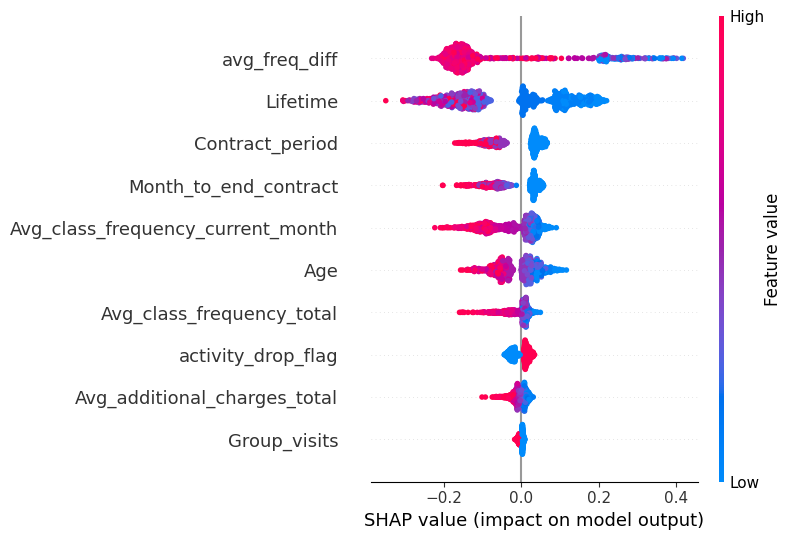

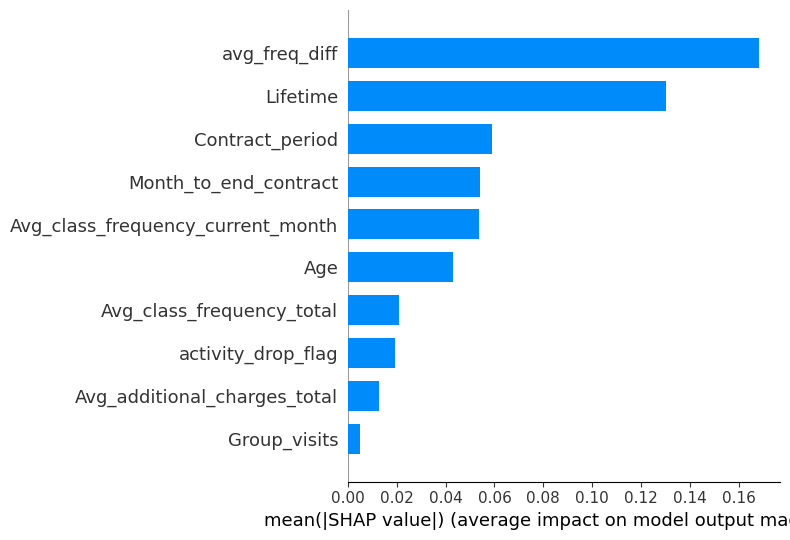

In [84]:
shap.summary_plot(
    shap_class1,
    X_test,
    plot_type="dot",
    max_display=10
)

shap.summary_plot(
    shap_class1,
    X_test,
    plot_type="bar",
    max_display=10
)

Модель показала высокую точность: **AUC-ROC** = 0.981 и **F1-score** = 0.886, что говорит о хорошей способности различать клиентов, которые уйдут, и тех, кто останется. SHAP-анализ подтвердил, что главными факторами риска оттока являются снижение активности (**avg_freq_diff**) и короткий контракт (**Contract_period**), а также длительность пребывания клиента в клубе (**Lifetime**). Эти результаты позволяют не только предсказывать отток, но и объяснять, какие признаки на него влияют, что важно для бизнес-решений.

# **Оценка риска оттока**

In [85]:
# Получаем предсказанную вероятность оттока
y_proba_rf = rf.predict_proba(X_test)[:,1]

df_risk = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_proba_rf
})

In [91]:
# Разбиваем на группы и считаем долю ушедших
df_risk['risk_group'] = pd.cut(
    df_risk['y_proba'],
    bins=[0, 0.3, 0.6, 1.0],  # Low: 0-0.3, Medium: 0.3-0.6, High: 0.6-1
    labels=['Low', 'Medium', 'High']
)

risk_summary = df_risk.groupby('risk_group')['y_true'].mean().reset_index()
#risk_summary['y_true_percent'] = risk_summary['y_true'] * 100
print(risk_summary)

  risk_group    y_true
0        Low  0.020588
1     Medium  0.253165
2       High  0.908714


/tmp/ipython-input-52120342.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_summary = df_risk.groupby('risk_group')['y_true'].mean().reset_index()


/tmp/ipython-input-3741247953.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='risk_group', y='y_true_percent', data=risk_summary, palette='Set1')


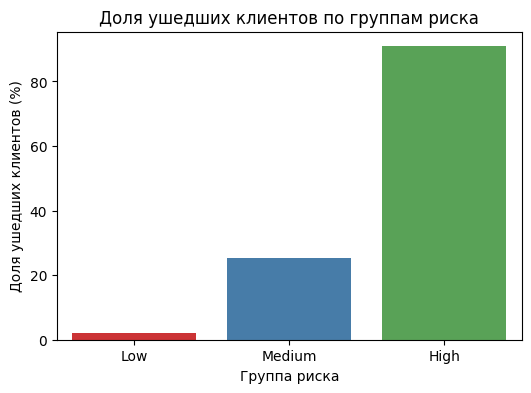

In [90]:
# Визуализация
plt.figure(figsize=(6,4))
sns.barplot(x='risk_group', y='y_true_percent', data=risk_summary, palette='Set1')
plt.ylabel('Доля ушедших клиентов (%)')
plt.xlabel('Группа риска')
plt.title('Доля ушедших клиентов по группам риска')
plt.show()

Модель успешно сегментирует клиентов по риску оттока. В группе “High risk” уходят почти все клиенты (~90%), тогда как в группе “Low risk” только 2%. Это подтверждает, что модель эффективно выделяет клиентов, на которых стоит сосредоточить усилия по удержанию.

# **Краткие бизнес-рекомендации**
* **High risk**: сконцентрировать удерживающие акции, индивидуальные предложения, мотивировать продление контрактов.

* **Medium risk**: следить за активностью, вовлечением, рассылать промо-акции.

* **Low risk**: поддерживать стандартный сервис, не тратить ресурсы лишние.



По топ-факторам оттока: короткий контракт, падение активности, низкие доп. траты => направленные меры (например, бонус за годовой контракт, персональные предложения по доп. услугам, уведомления о пропущенных занятиях).